# Bicycle classification - part 2

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#from Functions import BIKED_classif_functions as BIKED
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.tree import DecisionTreeClassifier     #Depth-8 Decision Tree
from sklearn.neighbors import KNeighborsClassifier  #K-Neighbors
from sklearn.ensemble import RandomForestClassifier #Random Forest


from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn import set_config


In [2]:
#Read Data
data = pd.read_csv("Data/BIKED_processed.csv", index_col=0).copy()
reduced = pd.read_csv("Data/BIKED_reduced.csv", index_col=0).copy()


In [3]:
data.shape    # (4512, 2401)
reduced.shape # (4512, 1320)

(4512, 1320)

## Create Categories of Bicycles

In [4]:
#get column BIKESTYLE (label)
data["BIKESTYLE"] = reduced["BIKESTYLE"]
data.BIKESTYLE.value_counts()


ROAD          1856
MTB            616
TRACK          470
OTHER          315
DIRT_JUMP      293
TOURING        201
CYCLOCROSS     151
POLO           128
TIMETRIAL       89
BMX             86
COMMUTER        75
CITY            72
CRUISER         42
HYBRID          39
TRIALS          35
GRAVEL          19
CARGO           14
CHILDRENS       10
FAT              1
Name: BIKESTYLE, dtype: int64

In [5]:
#drop <0.1% of values
#data = BIKED.remove_classes_with_less_than_x_percent(data)

classes = data["BIKESTYLE"].value_counts()
classes = classes.reset_index()
    
# new column 'percent'
classes["percent"] = (classes["BIKESTYLE"] / data.shape[0] * 100).round(2)
classes = classes.loc[classes["percent"] >= 0.1, :]

# keep all rows that have a lable that is in classes
classes.columns = ["BIKESTYLE", "COUNT", "PERCENT"]
#data = data.loc[data[label_col].isin(list(classes["BIKESTYLE"])), :] # doesn't work

data = data.merge(classes, on="BIKESTYLE")
data.BIKESTYLE.value_counts()



ROAD          1856
MTB            616
TRACK          470
OTHER          315
DIRT_JUMP      293
TOURING        201
CYCLOCROSS     151
POLO           128
TIMETRIAL       89
BMX             86
COMMUTER        75
CITY            72
CRUISER         42
HYBRID          39
TRIALS          35
GRAVEL          19
CARGO           14
CHILDRENS       10
Name: BIKESTYLE, dtype: int64

In [6]:
# I select all BIKESTYLES for a certain category 
# Then I assign a value

roadbike = ["ROAD", "TRACK", "TIMETRIAL"]
off_road = ["MTB", "TRIALS", "DIRT_JUMP", "BMX", "CYCLOCROSS", "GRAVEL", "POLO"]
everyday = ["TOURING", "COMMUTER", "CITY", "CRUISER", "HYBRID", "CARGO", "CHILDRENS"]

#col_i_BIKESTYLE = data.columns.get_loc("BIKESTYLE")
#col_i_category = data.columns.get_loc("category")

data["category"] = "Other"
data.loc[data["BIKESTYLE"].isin(roadbike), "category"] = "Road_Race"
data.loc[data["BIKESTYLE"].isin(off_road), "category"] = "Off_Road"
data.loc[data["BIKESTYLE"].isin(everyday), "category"] = "Everyday"
data.category.value_counts()

/var/folders/qk/t0n17tjd6xg2853ctsfg5xz80000gn/T/ipykernel_44707/3215727690.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["category"] = "Other"


Road_Race    2415
Off_Road     1328
Everyday      453
Other         315
Name: category, dtype: int64

In [7]:
#to defragment (see warning before)
data = data.copy()


In [8]:
#category Road_Race is quite big
#can I make it smaller? 
# --> yes. I put Cyclocross and Polo in the off-road category

data.loc[(data.category == "Off_Road"), ["category", "BIKESTYLE"]].value_counts()


category  BIKESTYLE 
Off_Road  MTB           616
          DIRT_JUMP     293
          CYCLOCROSS    151
          POLO          128
          BMX            86
          TRIALS         35
          GRAVEL         19
dtype: int64

In [9]:
data.groupby(["category", "BIKESTYLE"]).count().sort_values

<bound method DataFrame.sort_values of                       SSSIDECX3  SSSIDECX2  SSSIDECX1  SSSIDECY2  SSSIDECY1  \
category  BIKESTYLE                                                           
Everyday  CARGO              14         14         14         14         14   
          CHILDRENS          10         10         10         10         10   
          CITY               72         72         72         72         72   
          COMMUTER           75         75         75         75         75   
          CRUISER            42         42         42         42         42   
          HYBRID             39         39         39         39         39   
          TOURING           201        201        201        201        201   
Off_Road  BMX                86         86         86         86         86   
          CYCLOCROSS        151        151        151        151        151   
          DIRT_JUMP         293        293        293        293        293   
          GRA

In [10]:
#I could let "Other" and "Everyday" join together (not now)

# Clean up the SIZE-columns

In [11]:
data["SIZE"] = reduced["SIZE"]
data.loc[data["SIZE"].isna(), "SIZE"] = 0
data.SIZE.isna().value_counts()


False    4511
Name: SIZE, dtype: int64

In [12]:
data["SIZE"].value_counts().head(30)

0         998
54        280
56        229
52        179
26"       149
M         144
58        134
55        126
53        115
L         108
57         85
50         77
26         67
48         51
60         46
51         45
59         39
61         38
Large      37
27         30
S          29
XL         29
56cm       28
20         28
24"        26
20"        25
47         23
custom     23
49         22
24         21
Name: SIZE, dtype: int64

In [13]:
data["SIZE"].value_counts().tail(10)

56x57           1
56 c-c 56       1
570 c-c 565     1
gf              1
51 (compact)    1
52.5            1
ML              1
20.5TT          1
513             1
one             1
Name: SIZE, dtype: int64

### Create column `SIZE_in_cm`

In [14]:

# assign values to three columns:
# SIZE_in_cm
data["SIZE_in_cm"] = 0
data.loc[(
    (data["SIZE"].isna() == False) &
    (
        (data["SIZE"].str.lower().str.contains(r"cm")) |
        (data["SIZE"] == "54") |
        (data["SIZE"] == "56") |
        (data["SIZE"] == "52") |
        (data["SIZE"] == "58") |
        (data["SIZE"] == "55") |
        (data["SIZE"] == "53") |
        (data["SIZE"] == "57") |
        (data["SIZE"] == "50") |
        (data["SIZE"] == "48") |
        (data["SIZE"] == "60") |
        (data["SIZE"] == "51") |
        (data["SIZE"] == "59") |
        (data["SIZE"] == "47") |
        (data["SIZE"] == "61") |
        (data["SIZE"] == "64") |
        (data["SIZE"] == "62") |
        (data["SIZE"] == "46") |
        (data["SIZE"] == "53.5") |
        (data["SIZE"] == "63") |
        (data["SIZE"] == "57.5") |
        (data["SIZE"] == "44") |
        (data["SIZE"] == "51.5") |
        (data["SIZE"] == "49") 
    )
    ), "SIZE_in_cm"] = data["SIZE"]


data.SIZE_in_cm.value_counts()


0             2738
54             280
56             229
52             179
58             134
              ... 
54cm.            1
63 cm (CC)       1
58cm.            1
58cm/ct          1
54.5cm           1
Name: SIZE_in_cm, Length: 86, dtype: int64

In [15]:
data.SIZE_in_cm = data.SIZE_in_cm.str.extract(r"([0-9][0-9])")
data.SIZE_in_cm.value_counts().head()


54    304
56    273
52    192
58    152
53    136
Name: SIZE_in_cm, dtype: int64

In [16]:
# also add the columns with mm
#data.loc[(
#    (data["SIZE"].isna() == False) &
#    (
#        (data["SIZE"].str.lower().str.contains(r"mm")) #|
#        (data["SIZE"].str.contains(r"([0-9][0-9][0-9])"))
#        )
#    ), "SIZE_in_cm"] = data["SIZE"]


In [17]:
data["SIZE_in_cm"].value_counts()

54    304
56    273
52    192
58    152
53    136
55    134
57     96
50     87
48     60
51     56
60     53
61     47
59     45
49     30
47     23
62     20
64     19
46     13
63     11
44      6
16      4
66      3
43      2
19      2
42      2
68      1
65      1
33      1
Name: SIZE_in_cm, dtype: int64

In [18]:
# in `SIZE_in_cm` set all is_na_values to 0
data.loc[data["SIZE_in_cm"].isna() == True, "SIZE_in_cm"] = 0
data.SIZE_in_cm.value_counts().head()

0     2738
54     304
56     273
52     192
58     152
Name: SIZE_in_cm, dtype: int64

In [19]:
# In `SIZE` set all values to 0 when they are already in SIZE_in_cm
data.loc[(data["SIZE_in_cm"] != 0), "SIZE"] = 0

In [20]:
data.loc[:, ["SIZE_in_cm", "SIZE"]].head(10) # yay! it worked! (second row)

,SIZE_in_cm,SIZE
0,0,0
1,55,0
2,0,10.5
3,0,MCP
4,46,0
5,0,"15"""
6,0,10.5
7,0,"21"""
8,0,"20,7"
9,0,Medium


### Create column `SIZE_in_inch`

In [21]:

#SIZE_inch
data["SIZE_in_inch"] = 0
data.loc[(
    (data["SIZE"].isna() == False) &
    ((data["SIZE"].str.lower().str.contains(r"inch"))| 
    (data["SIZE"].str.lower().str.contains(r"\'"))| 
    (data["SIZE"].str.lower().str.contains(r"\""))|
    (data["SIZE"].str.lower().str.contains(r"26"))| 
    (data["SIZE"].str.lower().str.contains(r"27"))| 
    (data["SIZE"].str.lower().str.contains(r"24"))| 
    (data["SIZE"].str.lower().str.contains(r"18"))| 
    (data["SIZE"].str.lower().str.contains(r"19"))| 
    (data["SIZE"].str.lower().str.contains(r"17"))| 
    (data["SIZE"].str.lower().str.contains(r"15"))| 
    (data["SIZE"].str.lower().str.contains(r"21"))| 
    (data["SIZE"].str.lower().str.contains(r"16"))| 
    (data["SIZE"].str.lower().str.contains(r"13,5"))| 
    (data["SIZE"].str.lower().str.contains(r"14"))| 
    (data["SIZE"].str.lower().str.contains(r"20")))
    ), "SIZE_in_inch"] = data["SIZE"]
data.SIZE_in_inch.value_counts()


0            3844
26"           149
26             67
27             30
20             28
             ... 
4'              1
19.5"           1
20,5"           1
23"             1
19 inches       1
Name: SIZE_in_inch, Length: 123, dtype: int64

In [22]:
data.SIZE_in_inch = data.SIZE_in_inch.str.extract(r"([0-9][0-9])")
data.SIZE_in_inch.value_counts().head()

26    229
20     93
24     53
19     37
27     34
Name: SIZE_in_inch, dtype: int64

In [23]:
# in `SIZE_inch` - Set all is_na_values to 0
data.loc[data["SIZE_in_inch"].isna() == True, "SIZE_in_inch"] = 0
data.SIZE_in_inch.value_counts().head()

# In `SIZE` set all values to 0 when they are already in SIZE_in_inch
data.loc[(data["SIZE_in_inch"] != 0), "SIZE"] = 0

data.loc[:, ["SIZE_in_inch", "SIZE"]].head(10) # yay! it worked!

,SIZE_in_inch,SIZE
0,0,0
1,0,0
2,0,10.5
3,0,MCP
4,0,0
5,15,0
6,0,10.5
7,21,0
8,20,0
9,0,Medium


### Create Column `SIZE_in_text`

In [24]:
#SIZE_text
data["SIZE_in_text"] = 0
data.loc[(
    (data["SIZE"].isna() == False) &
    (data["SIZE"].str.lower().isin(["xs", "s", "m", "l", "xl", "xxl", "xxxl", "small", "medium", "large", "med", "big"]))
    ), "SIZE_in_text"] = data["SIZE"].str.lower()
data.SIZE_in_text.value_counts()

0         3992
m          165
l          113
large       50
medium      42
s           39
xl          38
small       24
med         17
big         12
xxl         11
xs           5
xxxl         3
Name: SIZE_in_text, dtype: int64

In [25]:
#replace 'large' with 'l', etc.
data.loc[data["SIZE_in_text"].isin(["large", "big"]), "SIZE_in_text"] = 'l'
data.loc[data["SIZE_in_text"] == "small", "SIZE_in_text"] = 's'
data.loc[data["SIZE_in_text"].isin(["medium", "med"]), "SIZE_in_text"] = 'm'

In [26]:
# in `SIZE_text` - Set all is_na_values to 0
data.loc[data["SIZE_in_text"].isna() == True, "SIZE_in_text"] = 0
data.SIZE_in_text.value_counts().head()


0     3992
m      224
l      175
s       63
xl      38
Name: SIZE_in_text, dtype: int64

In [27]:
# In `SIZE` set all values to 0 when they are already in SIZE_in_text
data.loc[(data["SIZE_in_text"] != 0), "SIZE"] = 0

data.loc[:, ["SIZE_in_text", "SIZE"]].sample(10) # yay! it worked! 

,SIZE_in_text,SIZE
1023,0,0
124,m,0
896,0,0
3688,0,0
1669,0,0
1586,0,56 c-c 56
430,0,0
1103,0,0
1892,0,0
1616,0,0


In [28]:
# do some more things here, check what is still left
data.SIZE.value_counts().head(20)

0               3952
custom            23
Custom            20
1SFA               9
?                  8
--                 6
500                6
525                6
535                6
34                 5
480                5
45                 5
43                 5
550                5
a                  5
29                 5
:Large             4
L (Short TT)       4
13                 4
66                 4
Name: SIZE, dtype: int64

### create new column `SIZE_other`



In [29]:
data["SIZE_other"] = 0
data.loc[data["SIZE"]!= 0, "SIZE_other"] = 1
data.SIZE_other.value_counts()

0    3952
1     559
Name: SIZE_other, dtype: int64

### Drop Column `SIZE`

In [30]:
data = data.drop("SIZE", axis=1)

### Drop all columns that are OneHotEncoded with 'SIZE OHCLASS'  (555 columns)

In [31]:
# these columns need to be deleted
SIZE_OH_cols = data.loc[:, data.columns.str.contains(r"SIZE OHCLASS")]
list(SIZE_OH_cols.columns)

['SIZE OHCLASS:  ',
 'SIZE OHCLASS:  14,5 ',
 'SIZE OHCLASS:  56/57',
 'SIZE OHCLASS:  John560',
 'SIZE OHCLASS:  MEDIUM',
 'SIZE OHCLASS:  SMALL',
 'SIZE OHCLASS:  XL',
 'SIZE OHCLASS: -',
 'SIZE OHCLASS: --',
 'SIZE OHCLASS: ---------',
 'SIZE OHCLASS: .',
 'SIZE OHCLASS: 0.505',
 'SIZE OHCLASS: 00',
 'SIZE OHCLASS: 01',
 'SIZE OHCLASS: 1',
 'SIZE OHCLASS: 1 size',
 'SIZE OHCLASS: 1.26',
 'SIZE OHCLASS: 10',
 'SIZE OHCLASS: 10.5',
 'SIZE OHCLASS: 100',
 'SIZE OHCLASS: 11',
 'SIZE OHCLASS: 11"',
 'SIZE OHCLASS: 11,5"',
 'SIZE OHCLASS: 11.5"',
 'SIZE OHCLASS: 11.8"',
 'SIZE OHCLASS: 12',
 'SIZE OHCLASS: 12"',
 'SIZE OHCLASS: 12.2',
 'SIZE OHCLASS: 12.5 inch',
 'SIZE OHCLASS: 12.5"',
 'SIZE OHCLASS: 12/24',
 'SIZE OHCLASS: 12/26',
 'SIZE OHCLASS: 13',
 'SIZE OHCLASS: 13"',
 'SIZE OHCLASS: 13,5',
 'SIZE OHCLASS: 13,5/26',
 'SIZE OHCLASS: 14',
 'SIZE OHCLASS: 14 ',
 'SIZE OHCLASS: 14"',
 'SIZE OHCLASS: 14,5',
 'SIZE OHCLASS: 15',
 'SIZE OHCLASS: 15"',
 'SIZE OHCLASS: 15,5',
 'SIZE OHCLASS

In [32]:
#drop all columns with SIZE OHCLASS
data.drop(list(SIZE_OH_cols.columns), axis = 1, inplace=True)

In [33]:
data.shape

(4511, 1854)

### Condense columns with `bottle SEATTUBE0`and `bottle DOWNTUBE0`(15 columns)

In [34]:
# check out some values
data["bottle DOWNTUBE0 SIZE"].value_counts()

# idea is to have two columns:
# * `bottle_Seattube` (0 or 1)
# * `bottle_Downtume` (0 or 1)



1    3952
0     293
2     216
3      50
Name: bottle DOWNTUBE0 SIZE, dtype: int64

In [35]:
data["bottle DOWNTUBE0 SIZE"].isna().value_counts()

False    4511
Name: bottle DOWNTUBE0 SIZE, dtype: int64

In [36]:
data["bottle DOWNTUBE0 WBY"].value_counts()

 14.0     4116
 11.2       51
 13.2       46
 6.0        29
 12.2       25
 10.0       24
 13.6       24
 12.8       22
 13.3       17
 5.0        16
 12.9       13
 18.0       13
 12.0       13
 11.6       10
 12.6        9
 8.0         9
 10.4        8
 7.0         7
 12.1        6
 9.0         5
-11.6        5
 15.0        5
 16.0        5
 13.8        4
 12.4        4
 10.5        3
 4.0         3
 14.2        3
 0.0         2
 14.4        2
 6.8         2
 3.0         1
-105.0       1
 1.0         1
 11.0        1
-114.0       1
 8.4         1
 7.5         1
 8.5         1
 13.0        1
 10.8        1
Name: bottle DOWNTUBE0 WBY, dtype: int64

It seems that in the processed dataset there are no missing values for the bottle-columns any more. 
Let's check them out in the reduced dataset.

In [37]:
reduced["bottle DOWNTUBE0 SIZE"].value_counts()

1.0    2304
0.0     220
2.0     183
3.0      50
Name: bottle DOWNTUBE0 SIZE, dtype: int64

In [38]:
reduced["bottle DOWNTUBE0 SIZE"].isna()

1        True
2        True
3        True
4       False
5        True
        ...  
4796    False
4797    False
4798    False
4799    False
4800    False
Name: bottle DOWNTUBE0 SIZE, Length: 4512, dtype: bool

So there are missing values in the reduced-dataset, (1755) but not in the processed one

In [39]:
data["bottle DOWNTUBE0 SIZE_reduced"] = reduced["bottle DOWNTUBE0 SIZE"]
data.loc[data["bottle DOWNTUBE0 SIZE_reduced"].isna(), "bottle DOWNTUBE0 SIZE"]

0       1
1       1
2       1
3       1
5       1
       ..
4498    1
4499    1
4500    1
4502    1
4510    1
Name: bottle DOWNTUBE0 SIZE, Length: 1977, dtype: int64

In [40]:
#double-check if they are really NaN in reduced-dataset
reduced.loc[reduced["bottle DOWNTUBE0 SIZE"].isna(), "bottle DOWNTUBE0 SIZE"]

1      NaN
2      NaN
3      NaN
5      NaN
6      NaN
        ..
4770   NaN
4771   NaN
4773   NaN
4774   NaN
4781   NaN
Name: bottle DOWNTUBE0 SIZE, Length: 1755, dtype: float64

**CONCLUSION**

In `bottle DOWNTUBE0 SIZE` all NaNs got converted to 1

Let's check out the other columns. 

Here they are with their respecting missing values:
* bottle SEATTUBE0 WBL	3088
* bottle SEATTUBE0 WBD	3088
* bottle SEATTUBE0 WBX	3088
* bottle SEATTUBE0 WBY	3088
* bottle SEATTUBE0 SIZE	3088
* bottle SEATTUBE0 X    3088
* bottle SEATTUBE0 CAGE	3088
* bottle DOWNTUBE0 SIZE	1755
* bottle DOWNTUBE0 WBY	1755
* bottle DOWNTUBE0 WBX	1755
* bottle DOWNTUBE0 WBL	1755
* bottle DOWNTUBE0 WBD	1755
* bottle DOWNTUBE0 flip	1755
* bottle DOWNTUBE0 X    1755
* bottle DOWNTUBE0 CAGE	1755



**CONCLUSION**

* All 7 `SEATTUBE-bottle`cols have 3088 missing values.
* All 7 `DOWNTUBE-bottle`cols have 1755 missing values.

In [41]:
#get all columns from data (without missing values)
data.loc[:, data.columns.str.contains(r"bottle")]

,Waterbottle boss spacing,bottle SEATTUBE0 WBL,bottle SEATTUBE0 WBD,bottle SEATTUBE0 WBX,bottle SEATTUBE0 WBY,bottle SEATTUBE0 SIZE,bottle DOWNTUBE0 SIZE,bottle SEATTUBE0 X,bottle DOWNTUBE0 WBY,bottle DOWNTUBE0 WBX,...,bottle DOWNTUBE0 WBD,bottle SEATTUBE0 CAGE,bottle DOWNTUBE0 flip,bottle DOWNTUBE0 X,bottle DOWNTUBE0 CAGE,bottle SEATTUBE0 show OHCLASS: False,bottle SEATTUBE0 show OHCLASS: True,bottle DOWNTUBE0 show OHCLASS: False,bottle DOWNTUBE0 show OHCLASS: True,bottle DOWNTUBE0 SIZE_reduced
0,65,208,73.5,15,14.0,1,1,196,14.0,15.0,...,73.5,1,0,204.0,0,1.0,0.0,1.0,0.0,NaN
1,65,201,73.5,15,14.0,1,1,140,14.0,15.0,...,73.5,0,0,200.0,0,1.0,0.0,1.0,0.0,NaN
2,65,201,73.5,15,14.0,1,1,190,14.0,15.0,...,73.5,1,0,200.0,0,1.0,0.0,1.0,0.0,NaN
3,68,208,73.5,15,14.0,1,1,194,14.0,15.0,...,73.5,1,0,200.0,1,1.0,0.0,1.0,0.0,NaN
4,65,201,73.5,15,14.0,1,1,140,14.0,15.0,...,73.5,0,0,200.0,0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4506,65,201,73.5,15,14.0,1,1,200,14.0,15.0,...,73.5,1,0,200.0,1,1.0,0.0,1.0,0.0,1.0
4507,65,300,74.0,15,14.0,2,2,120,14.0,15.0,...,74.0,0,0,200.0,0,0.0,1.0,0.0,1.0,1.0
4508,65,201,73.5,15,14.0,1,1,200,14.0,15.0,...,73.5,1,0,200.0,1,0.0,1.0,0.0,1.0,1.0
4509,65,201,73.5,15,14.0,1,1,150,14.0,15.0,...,73.5,1,0,225.0,1,1.0,0.0,1.0,0.0,1.0


In [42]:
reduced.loc[:, reduced.columns.str.contains(r"bottle")]

,Waterbottle boss spacing,bottle SEATTUBE0 show,bottle SEATTUBE0 WBL,bottle SEATTUBE0 WBD,bottle SEATTUBE0 WBX,bottle SEATTUBE0 WBY,bottle DOWNTUBE0 show,bottle SEATTUBE0 SIZE,bottle DOWNTUBE0 SIZE,bottle SEATTUBE0 X,bottle DOWNTUBE0 WBY,bottle DOWNTUBE0 WBX,bottle DOWNTUBE0 WBL,bottle DOWNTUBE0 WBD,bottle SEATTUBE0 CAGE,bottle DOWNTUBE0 flip,bottle DOWNTUBE0 X,bottle DOWNTUBE0 CAGE
1,65.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,65.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,65.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,65.0,False,201.0,73.5,15.0,14.0,False,1.0,1.0,140.0,14.0,15.0,201.0,73.5,0.0,0.0,200.0,0.0
5,65.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,65.0,False,NaN,NaN,NaN,NaN,True,NaN,1.0,NaN,4.0,15.0,201.0,73.5,NaN,0.0,200.0,0.0
4797,65.0,False,NaN,NaN,NaN,NaN,False,NaN,1.0,NaN,14.0,15.0,201.0,73.5,NaN,0.0,200.0,1.0
4798,65.0,True,201.0,73.5,15.0,14.0,True,1.0,1.0,200.0,14.0,15.0,201.0,73.5,1.0,0.0,200.0,1.0
4799,65.0,True,201.0,73.5,15.0,14.0,True,1.0,1.0,200.0,14.0,15.0,201.0,73.5,1.0,0.0,200.0,1.0


**CONCLUSION**

* `data` found 21 columns (14 was must)
* `reduced` found 18 columns (14 was must)
* `reduced` has columsn that are called `show`etc.
* It looks like all SEATTUBE_cols have entries at the same position



### checking on how I can reduce the bottle-columns

How do the columns correlate?

In [43]:
bottle_cols_reduced = reduced.loc[:, reduced.columns.str.contains(r"bottle")]

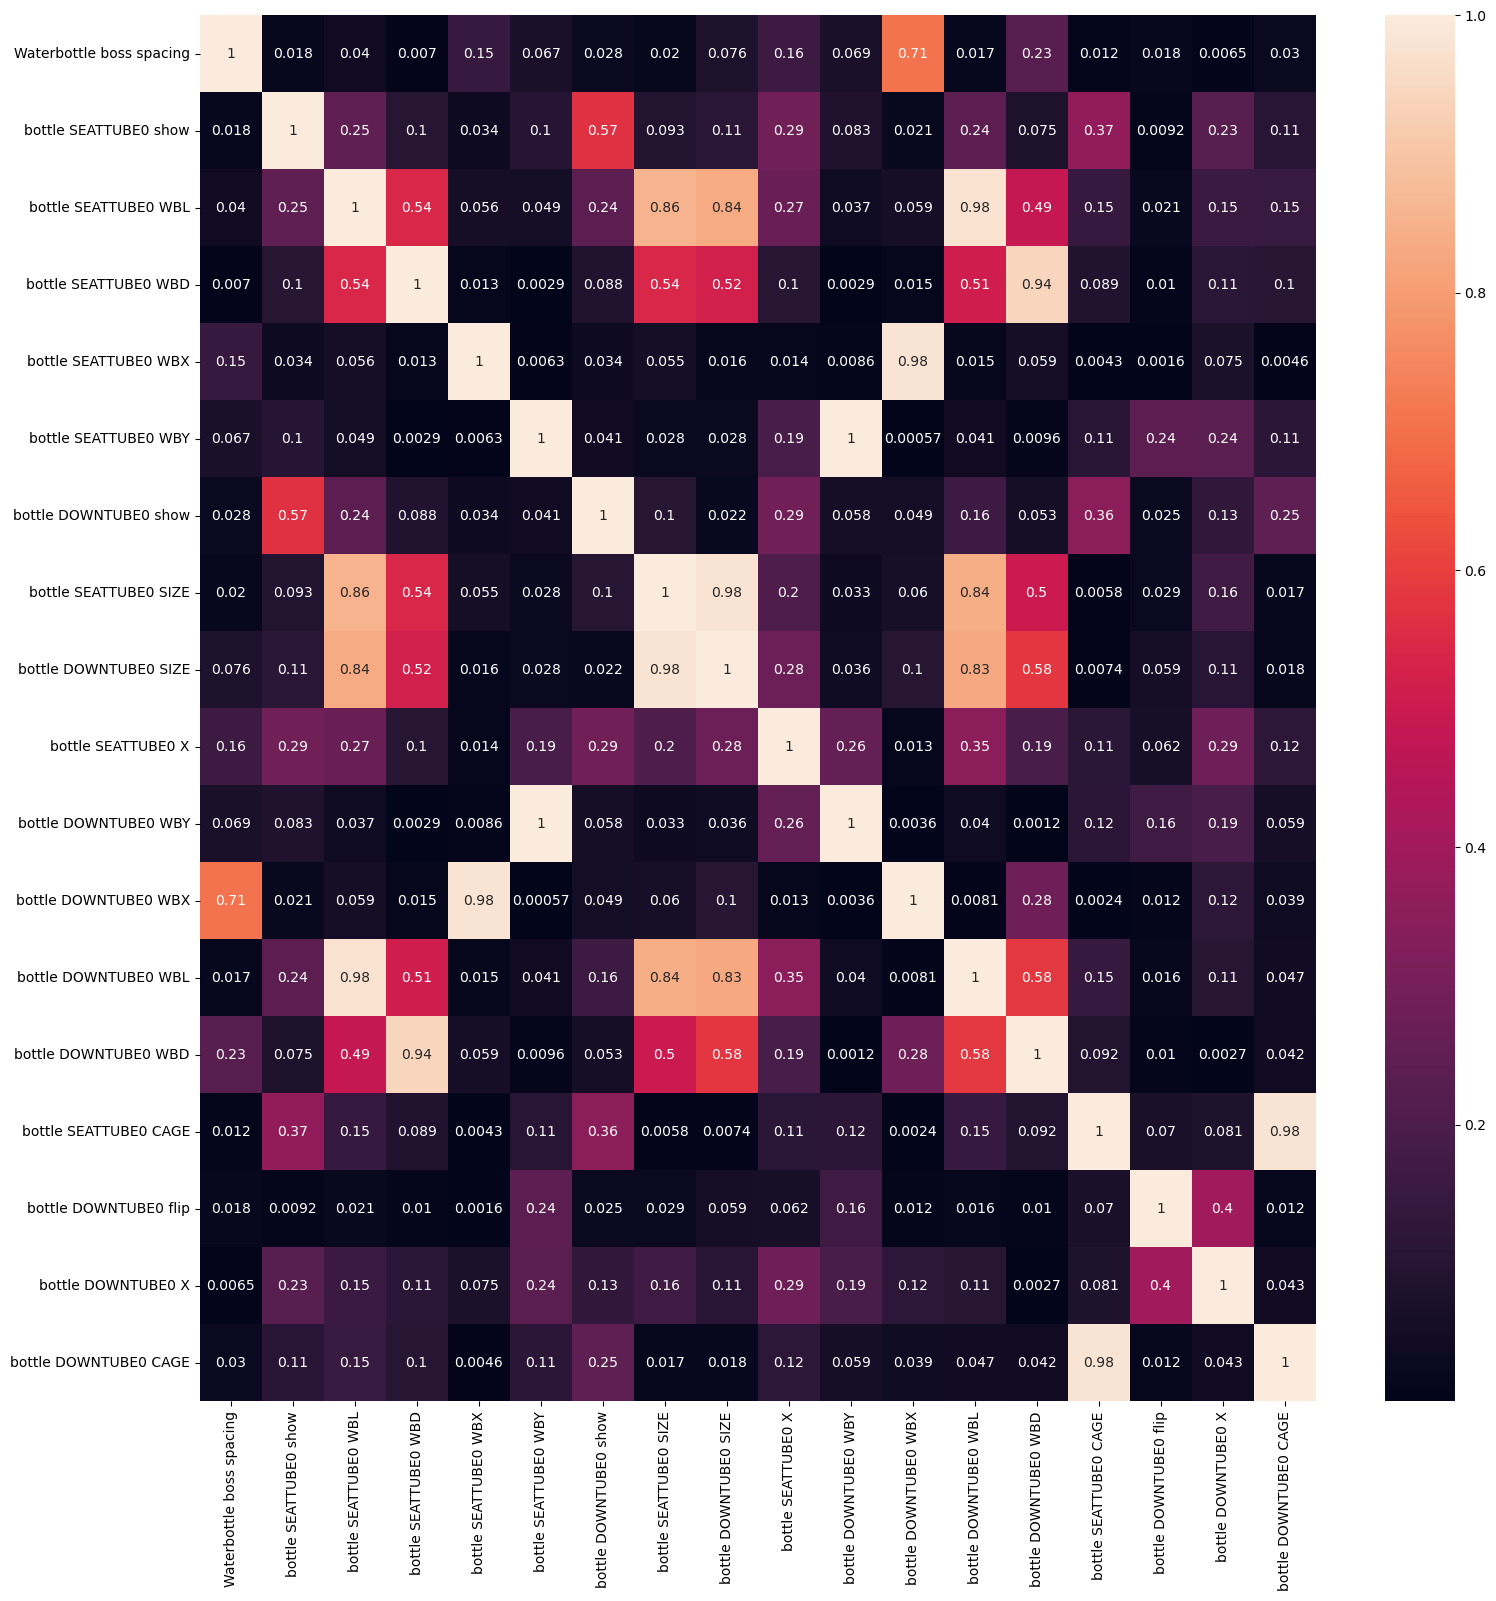

In [44]:
#looking at the columns
corrMatrix_reduced_all_bottle_cols = bottle_cols_reduced.corr().abs()

# Plot a heatmap of the correlation matrix.
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(corrMatrix_reduced_all_bottle_cols, annot=True);

In [45]:
bottle_cols_data = data.loc[:, data.columns.str.contains(r"bottle")]

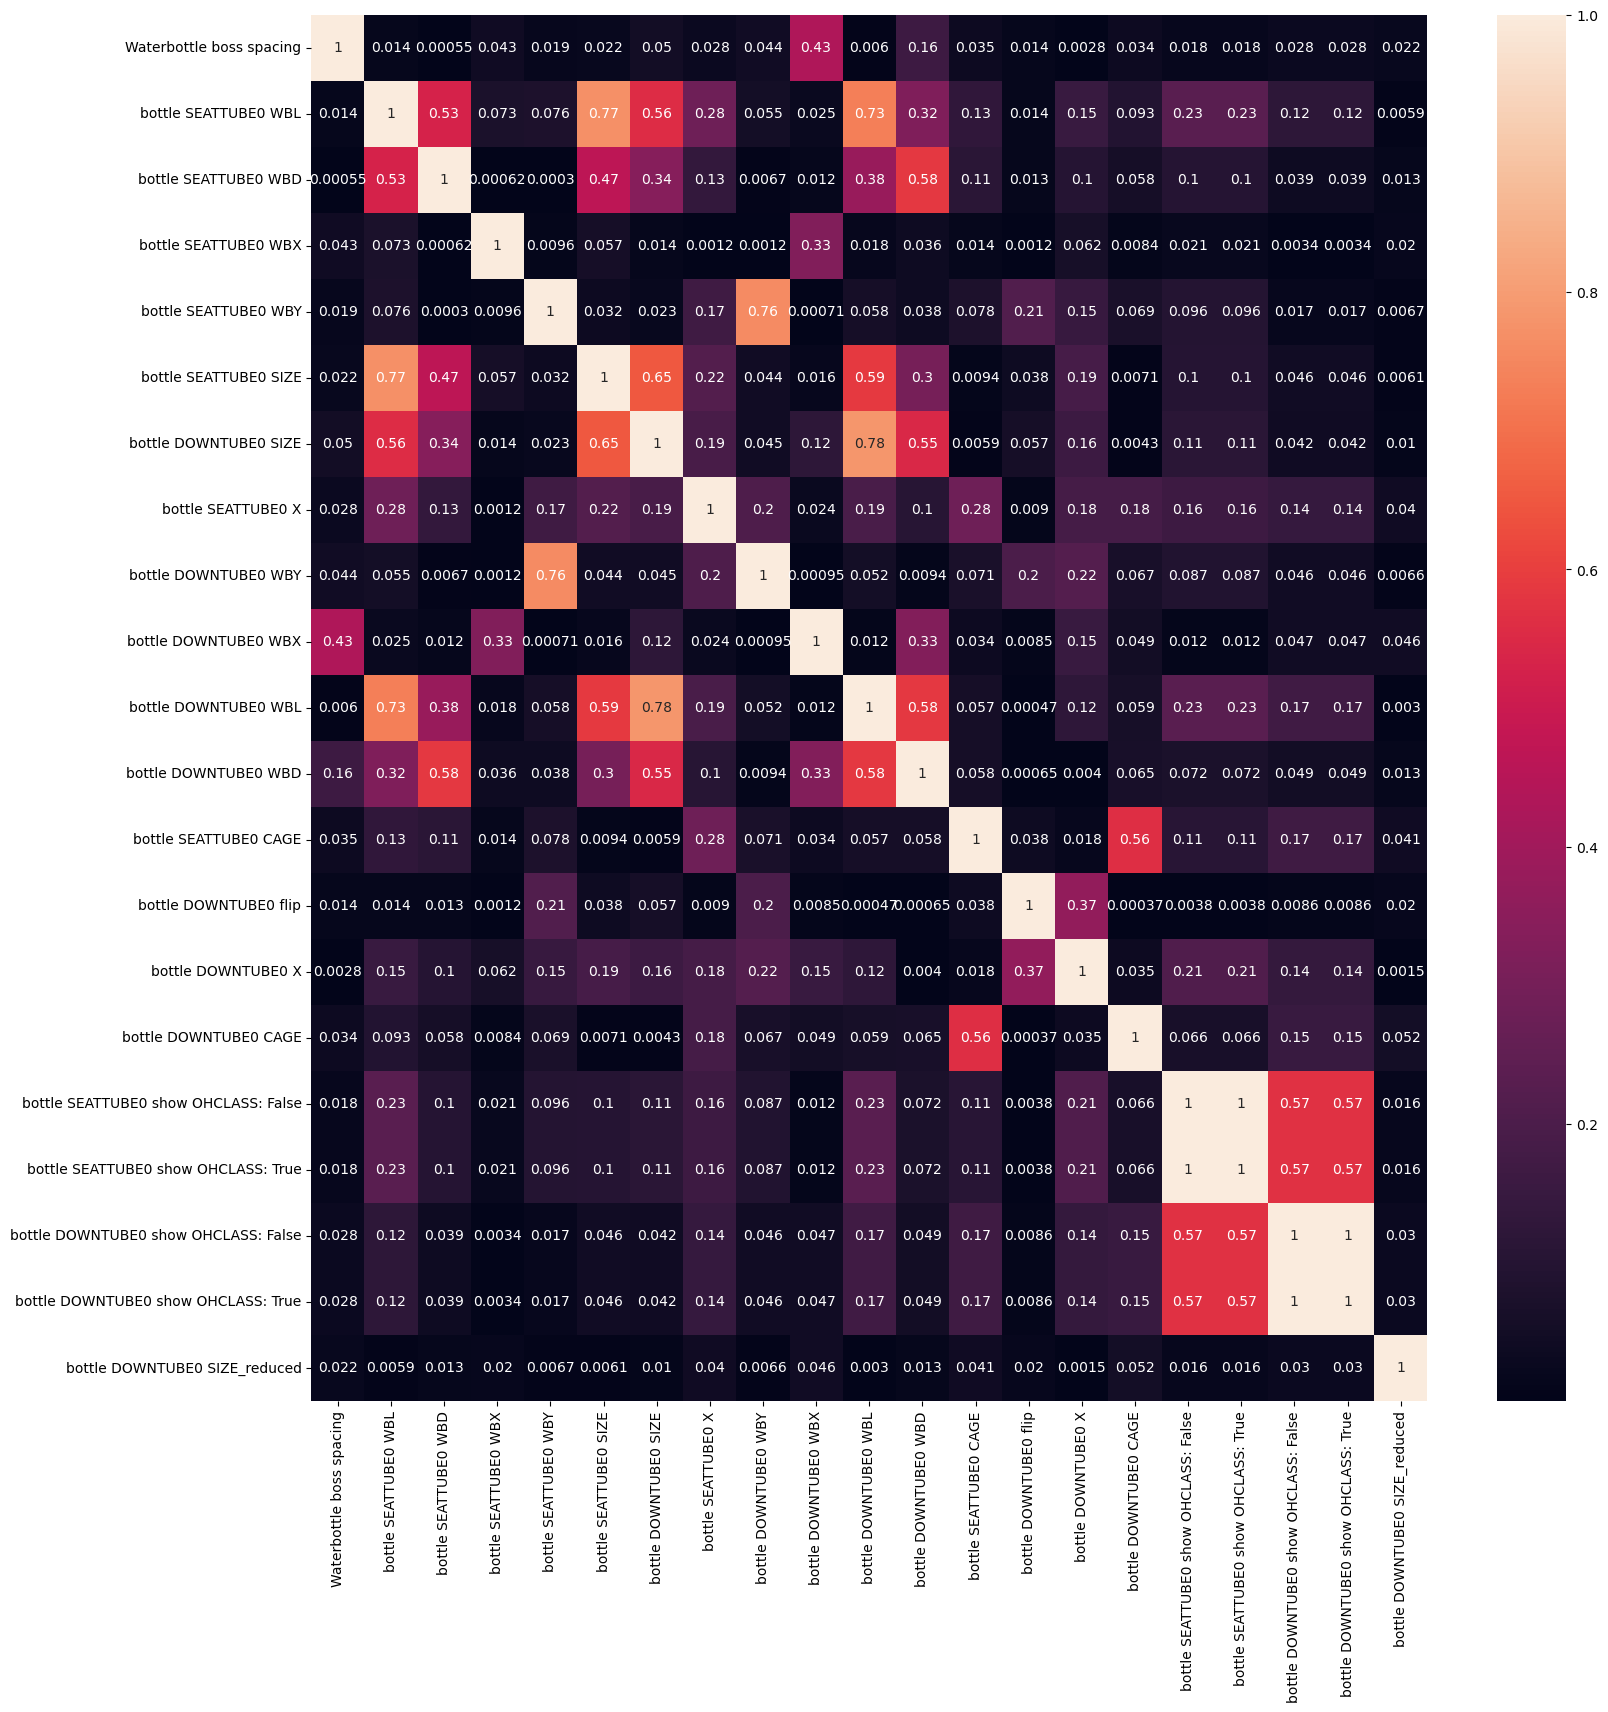

In [46]:
#looking at the columns
corrMatrix = bottle_cols_data.corr().abs()

# Plot a heatmap of the correlation matrix.
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(corrMatrix, annot=True);

### it looks like the type at the end has a high correlation

In [47]:
seattube0_cols_data = reduced.loc[:, reduced.columns.str.contains(r"SEATTUBE0")]

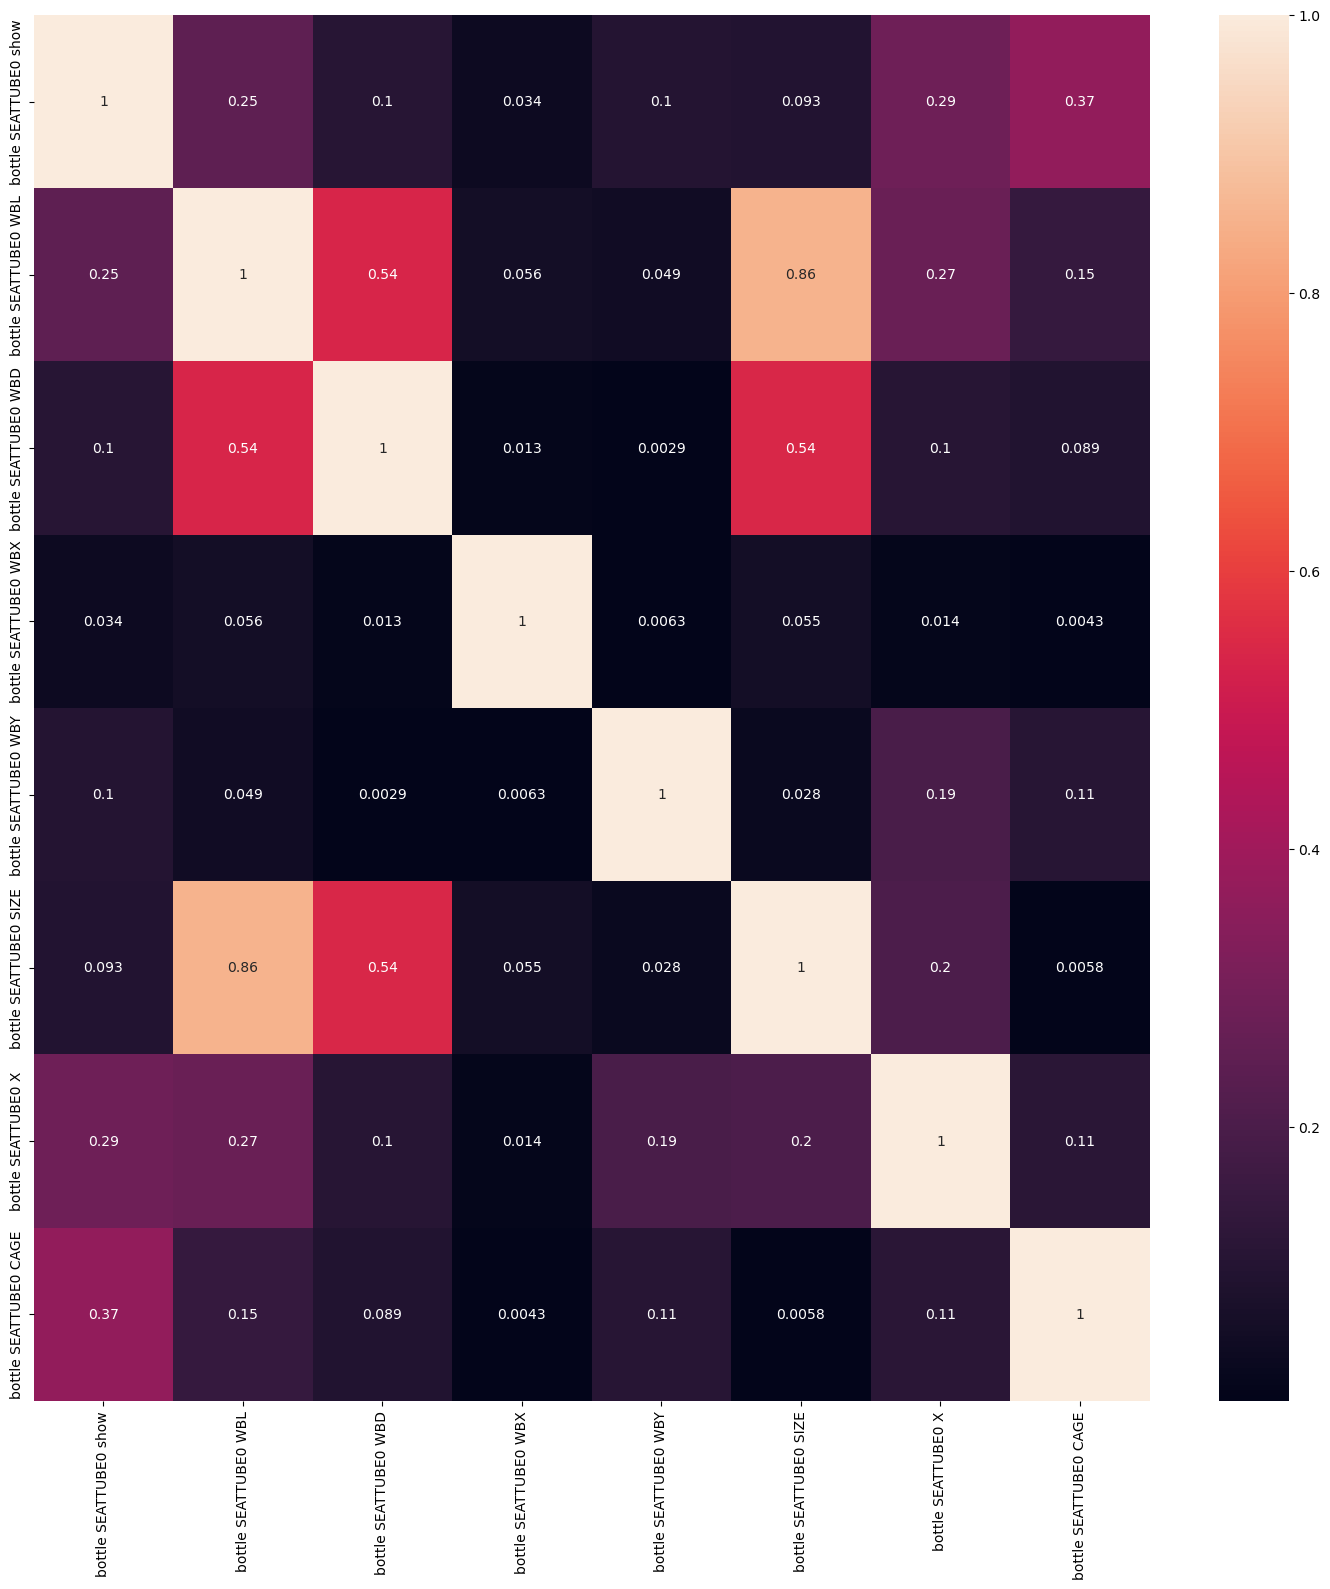

In [48]:
#looking at the columns
corrMatrix = seattube0_cols_data.corr().abs()

# Plot a heatmap of the correlation matrix.
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(corrMatrix, annot=True);

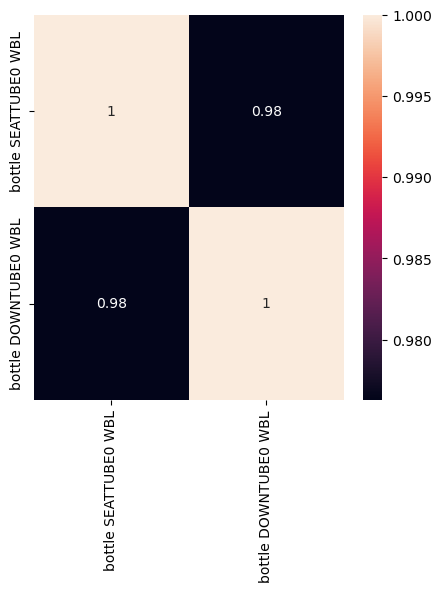

In [49]:
WBL_cols_data = reduced.loc[:, reduced.columns.str.contains(r" WBL")]
#looking at the columns
corrMatrix = WBL_cols_data.corr().abs()

# Plot a heatmap of the correlation matrix.
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(corrMatrix, annot=True);

**CONCLUSION**

* I can't make sense of it. 
* Rejected: All `Bottle Seattube`s are in the same rows.
* Rejected: All `Bottle DOWNtube`s are in the same rows.
* But at least I can drop all highly correlated columns. (did it)

* And I can impute the missing values with 0 (didn't do it)

In [50]:
# Select the upper triangle of the correlation matrix.
upper = corrMatrix_reduced_all_bottle_cols.where(
    np.triu(np.ones(corrMatrix_reduced_all_bottle_cols.shape), k=1).astype(bool)
    )

upper

,Waterbottle boss spacing,bottle SEATTUBE0 show,bottle SEATTUBE0 WBL,bottle SEATTUBE0 WBD,bottle SEATTUBE0 WBX,bottle SEATTUBE0 WBY,bottle DOWNTUBE0 show,bottle SEATTUBE0 SIZE,bottle DOWNTUBE0 SIZE,bottle SEATTUBE0 X,bottle DOWNTUBE0 WBY,bottle DOWNTUBE0 WBX,bottle DOWNTUBE0 WBL,bottle DOWNTUBE0 WBD,bottle SEATTUBE0 CAGE,bottle DOWNTUBE0 flip,bottle DOWNTUBE0 X,bottle DOWNTUBE0 CAGE
Waterbottle boss spacing,NaN,0.0179,0.039963,0.006990,0.146589,0.067201,0.028239,0.020038,0.075815,0.161732,0.069367,0.706495,0.017311,0.233451,0.011789,0.017674,0.006549,0.029858
bottle SEATTUBE0 show,NaN,NaN,0.246638,0.104536,0.034489,0.100127,0.567833,0.092806,0.113695,0.287182,0.083341,0.020746,0.238924,0.075360,0.365538,0.009222,0.230523,0.106147
bottle SEATTUBE0 WBL,NaN,NaN,NaN,0.539644,0.055894,0.049439,0.242013,0.855348,0.835345,0.273268,0.037259,0.058701,0.976300,0.487874,0.145894,0.020940,0.154648,0.149827
bottle SEATTUBE0 WBD,NaN,NaN,NaN,NaN,0.013466,0.002929,0.087859,0.541371,0.520433,0.104787,0.002862,0.014637,0.514771,0.943910,0.088854,0.010285,0.111315,0.102629
bottle SEATTUBE0 WBX,NaN,NaN,NaN,NaN,NaN,0.006330,0.034381,0.055008,0.015505,0.013642,0.008580,0.979097,0.014534,0.059015,0.004321,0.001609,0.074501,0.004626
bottle SEATTUBE0 WBY,NaN,NaN,NaN,NaN,NaN,NaN,0.041331,0.028207,0.027746,0.194334,0.999045,0.000567,0.040810,0.009584,0.107383,0.241442,0.237983,0.114570
bottle DOWNTUBE0 show,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.104490,0.022147,0.289479,0.057619,0.049403,0.161453,0.052950,0.355525,0.025418,0.131135,0.245248
bottle SEATTUBE0 SIZE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.977068,0.204084,0.032577,0.059724,0.840216,0.499033,0.005771,0.029420,0.164828,0.016982
bottle DOWNTUBE0 SIZE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.276389,0.036178,0.104751,0.829429,0.580102,0.007384,0.059082,0.106236,0.018492
bottle SEATTUBE0 X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.259630,0.013204,0.351577,0.193407,0.113237,0.062371,0.285427,0.117868


In [51]:
# Find the index of those feature columns with correlation greater than 0.95.
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['bottle DOWNTUBE0 SIZE',
 'bottle DOWNTUBE0 WBY',
 'bottle DOWNTUBE0 WBX',
 'bottle DOWNTUBE0 WBL',
 'bottle DOWNTUBE0 CAGE']

In [52]:
data.shape

(4511, 1855)

In [53]:
# Drop the columns 
data = data.drop(columns=to_drop)

In [54]:
data.shape

(4511, 1850)

**CONCLUSION**

From `data` the following columns have been dropped
* ['bottle DOWNTUBE0 SIZE',
* 'bottle DOWNTUBE0 WBY',
*  'bottle DOWNTUBE0 WBX',
*  'bottle DOWNTUBE0 WBL',
*  'bottle DOWNTUBE0 CAGE']

because their counterpart in `SEATTUBE`was highly correlated.

## Cleaning up columns and save file

In [55]:
#check which bottle-columns remain
data.loc[:, data.columns.str.contains("bottle")]

,Waterbottle boss spacing,bottle SEATTUBE0 WBL,bottle SEATTUBE0 WBD,bottle SEATTUBE0 WBX,bottle SEATTUBE0 WBY,bottle SEATTUBE0 SIZE,bottle SEATTUBE0 X,bottle DOWNTUBE0 WBD,bottle SEATTUBE0 CAGE,bottle DOWNTUBE0 flip,bottle DOWNTUBE0 X,bottle SEATTUBE0 show OHCLASS: False,bottle SEATTUBE0 show OHCLASS: True,bottle DOWNTUBE0 show OHCLASS: False,bottle DOWNTUBE0 show OHCLASS: True,bottle DOWNTUBE0 SIZE_reduced
0,65,208,73.5,15,14.0,1,196,73.5,1,0,204.0,1.0,0.0,1.0,0.0,NaN
1,65,201,73.5,15,14.0,1,140,73.5,0,0,200.0,1.0,0.0,1.0,0.0,NaN
2,65,201,73.5,15,14.0,1,190,73.5,1,0,200.0,1.0,0.0,1.0,0.0,NaN
3,68,208,73.5,15,14.0,1,194,73.5,1,0,200.0,1.0,0.0,1.0,0.0,NaN
4,65,201,73.5,15,14.0,1,140,73.5,0,0,200.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4506,65,201,73.5,15,14.0,1,200,73.5,1,0,200.0,1.0,0.0,1.0,0.0,1.0
4507,65,300,74.0,15,14.0,2,120,74.0,0,0,200.0,0.0,1.0,0.0,1.0,1.0
4508,65,201,73.5,15,14.0,1,200,73.5,1,0,200.0,0.0,1.0,0.0,1.0,1.0
4509,65,201,73.5,15,14.0,1,150,73.5,1,0,225.0,1.0,0.0,1.0,0.0,1.0


In [56]:
# drop columns from `reduced`-dataset: "bottle DOWNTUBE0 SIZE_reduced"
data = data.drop("bottle DOWNTUBE0 SIZE_reduced", axis = 1)

In [57]:
# drop columns "PERCENT" and "COUNT"
data = data.drop(["PERCENT", "COUNT"], axis = 1)

In [58]:
data.shape

(4511, 1847)

In [59]:
# save file

#store results
pd.DataFrame(data).to_csv("Data/data_processed_cl.csv")

**Remarks**

* I still have quite some textfield-columns (but they do not seem to be double)
* I still have some show-columns,
* I still have NaN-values in the reduced set, that have been interpolated with KNN(5) in the processed dataset. 
* this will all stay like this. 



# Next steps / thoughts

In [58]:
### BUT if I really want to finish, what do I need next? 

# 2) a way to find out if two bicycle types are similar 
# (confusion matrix), what do I do with false postives and true negatives

# 3) Is the difference statistically significant?

# 4) which features account for the difference? (decision tree? / random forest)
#    (or any other way to extract features)

#-----

# imbalanced - try model
# if it works fine - great
# if not: downsampling and upweighting 

#-----

# I wanted to get statistical differences between the classes. 
# Confusion Matrix is used both in Hypothesis Testing as well as in Classification Problems.
# Hypothesis Testing has a mean, and then I can compare if the difference in the other mean is statistically significant.
# The good thing is that I have understood now all measures of the confusion matrix: 
#  - Accuracy is correct_ones / all --> percentage of correctly classified over all
#  - F1-score is score made from equal parts Precision and Recall (Recall is also called Sensitivity in statistics).

#----

#In summary, the author evaluates a number of statistical tests to compare classification algorithms’ performance. 
# Base of the results, the author recommends two parametric statistical tests: 
# the Wilcoxon sighed ranks test (for comparing two classifiers) 
# and the Friedman test (for comparing more than two classifiers) over multiple data sets.

#-----


# For later use

```min_max_scaler = preprocessing.MinMaxScaler()
# min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(ImpDF.values)
# x_scaled=min_max_scaler.transform
scdf = pd.DataFrame(x_scaled, columns=ImpDF.columns,index=ImpDF.index.values)```